In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
from sklearn.utils.class_weight import compute_class_weight

In [3]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Add higher directory to python modules path.

import sys
sys.path.append("..")

In [5]:
# Local utility functions
from utilities import machine_learning_utils

****

## Load Data

In [6]:
import pickle

X_train,y_train,X_test,y_test,feature_names,words_train_df = pickle.load(open("../../generated_data/word_data_features.p","rb"))

X_train.shape,X_test.shape,feature_names.shape, words_train_df.shape

((35761, 3000), (11921, 3000), (3000,), (35761, 2))

In [7]:
# save original variables just in case
X_train0,y_train0 = X_train,y_train

*****

## Build classification model

### Undersampling by cleaning samples

####  Remove samples based on *Tomek Links*

In [8]:
from imblearn.under_sampling import TomekLinks

In [9]:
# ?TomekLinks
# sampling_strategy='auto' (default) : remove the sample of the tomek link that belongs to the bigger class
# sampling_strategy='all' : remove both samples of a tomek link
# returns: 
#   sample_indices_ : Indices of the samples selected.

In [12]:
tl = TomekLinks(sampling_strategy='auto', return_indices=False, random_state=1234, n_jobs=1, ratio=None)
X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
X_train_undersampled.shape, y_train_undersampled.shape

print(y_train.shape[0], y_train.shape[0]-y_train_undersampled.shape[0])
print(Counter(y_train_undersampled).items())

idx = list(set(range(0,X_train.shape[0]))-set(tl.sample_indices_))
assert(words_train_df.loc[idx,'lang_label'].nunique()==1)
print(words_train_df.loc[idx].word.tolist())

10416 119
dict_items([('MSA', 9749), ('TND', 548)])
['زحزح', 'والتي', 'تواني', 'ضمر', 'متغير', 'وزير', 'قسط', 'معلمة', 'برجولية', 'مكوي', 'خيب', 'تعملو', 'حوامة', 'نتفرج', 'متاع', 'زاءدة', 'بكتيري', 'مرحلي', 'عسل', 'جامد', 'نقولها', 'ايام', 'الجيزة', 'بينهم', 'مضمار', 'داكا', 'فيلق', 'عسف', 'بيرنيه', 'تحيا', 'بملا', 'رواح', 'يهمك', 'ملك', 'انشاء', 'قلا', 'حذو', 'عراك', 'وطنيا', 'غيط', 'بلطيق', 'تهجي', 'خبو', 'نحبكم', 'المعلم', 'تصحيح', 'يزيد', 'هاج', 'البارونات', 'جنوا', 'متعلم', 'عليهم', 'فارنهايتية', 'المساحة', 'توبة', 'ونحب', 'مستو', 'ياسيدي', 'كبش', 'شلرك', 'خدم', 'ضاهي', 'باتجاه', 'ديمومة', 'يبارك', 'ولادة', 'يخدع', 'الزهور', 'الهاتف', 'تيس', 'اعدام', 'شوط', 'زيف', 'فهمت', 'نشوف', 'وفقا', 'طهو', 'يعطي', 'باينت', 'تجبر', 'ماص', 'وجوه', 'شبيه', 'لنا', 'ام', 'الملا', 'الخبز', 'مهبط', 'تكذب', 'معلن', 'اذنا', 'يهتم', 'بايت', 'للناس', 'ما', 'دنو', 'ميلانو', 'قاد', 'محزن', 'رفاهية', 'فلوت', 'عضو', 'مزاج', 'يوليوس', 'فيينا', 'وصف', 'لحام', 'نعمة', 'نحبها', 'ويا', 'جابه', 'عباد', 'فوه', 'ع

In [14]:
# words_train_df.loc[idx,'lang_label'].value_counts()

#### Remove samples based on label consistency of nearest neighbours
Remove samples which do not agree “enough” with their neighboorhood.

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours

In [16]:
# ?EditedNearestNeighbours
# ?RepeatedEditedNearestNeighbours

In [17]:
enn = EditedNearestNeighbours(sampling_strategy='auto', return_indices=False, random_state=90210, n_neighbors=3, kind_sel='mode', n_jobs=1, ratio=None)
X_train_undersampled2, y_train_undersampled2 = enn.fit_resample(X_train, y_train)

print(y_train.shape, y_train.shape[0]-y_train_undersampled2.shape[0])
print(Counter(y_train_undersampled2).items())

idx2 = list(set(range(0,X_train.shape[0]))-set(enn.sample_indices_))
print(words_train_df.loc[idx2].word.tolist())

(10416,) 70
dict_items([('MSA', 9798), ('TND', 548)])
['لو', 'يهمك', 'يتيما', 'يهديك', 'علو', 'شن', 'معلن', 'يعجبني', 'نورو', 'القماش', 'يهتم', 'برشاش', 'عدو', 'لتوانيا', 'مشايع', 'مشابهة', 'كيلو', 'الزنا', 'معلمة', 'تعيش', 'طيش', 'هالوجين', 'بـ', 'دنو', 'برجولية', 'ميلانو', 'احناش', 'مزيلة', 'شوقا', 'تلاش', 'وينستون', 'انتعاش', 'خبو', 'متاع', 'هايبوتلاموس', 'توفالو', 'هاتف', 'يزيد', 'عسل', 'غشاش', 'ازال', 'هاج', 'تاعب', 'شوط', 'عاش', 'بيانو', 'نشوف', 'هايتي', 'يتفرج', 'يهلك', 'العدو', 'حاش', 'يزيل', 'متاعنا', 'متاعكم', 'وجوه', 'شبيه', 'خشخاش', 'معلق', 'مستو', 'داكا', 'عليك', 'ملغاش', 'لنا', 'اقدام', 'محلاه', 'رشاش', 'اليك', 'نيكولو', 'كبش']


C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [18]:
renn = RepeatedEditedNearestNeighbours(sampling_strategy='auto', return_indices=False, random_state=2019, 
                                       n_neighbors=5, max_iter=100, kind_sel='mode', n_jobs=1, ratio=None)
X_train_undersampled3, y_train_undersampled3 = renn.fit_resample(X_train, y_train)

print(y_train.shape, y_train.shape[0]-y_train_undersampled3.shape[0])
print(Counter(y_train_undersampled3).items())

idx3 = list(set(range(0,X_train.shape[0]))-set(renn.sample_indices_))
print(sorted(words_train_df.loc[idx3].word.tolist()))

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


(10416,) 52
dict_items([('MSA', 9816), ('TND', 548)])
['احناش', 'العدو', 'القماش', 'انتعاش', 'برشاش', 'بيانو', 'تعملو', 'تلاش', 'تمثيلها', 'توفالو', 'حاش', 'حلو', 'خبو', 'خشخاش', 'دنو', 'رشاش', 'شوش', 'عاش', 'عدو', 'علها', 'علو', 'غشاش', 'فوه', 'فيما', 'كلها', 'كيلو', 'لها', 'لو', 'ماش', 'مالاجاش', 'مالاغاش', 'متاع', 'متاعكم', 'متاعنا', 'متاعها', 'محلاه', 'مستو', 'مشايع', 'معلمة', 'ملغاش', 'ميلانو', 'نشوف', 'نقولها', 'نيكولو', 'هاليد', 'هايتي', 'وجوه', 'ولو', 'يبدو', 'يتيما', 'يعجبني', 'يعيش']


In [19]:
print(sorted(words_train_df.loc[idx].word.tolist()))
print("")
print(sorted(words_train_df.loc[idx2].word.tolist()))
print("")
print(sorted(words_train_df.loc[idx3].word.tolist()))

['اذنا', 'اعدام', 'البارونات', 'الجيزة', 'الخبز', 'الخرطوم', 'الزهور', 'المساحة', 'المعلم', 'الملا', 'الهاتف', 'ام', 'انشاء', 'ايام', 'باتجاه', 'بايت', 'باينت', 'برجولية', 'بز', 'بكتيري', 'بلطيق', 'بملا', 'بيرنيه', 'بينهم', 'تجبر', 'تحيا', 'تصحيح', 'تصطك', 'تصور', 'تعملو', 'تكذب', 'تهجي', 'تواني', 'توبة', 'تيس', 'جابه', 'جامد', 'جنوا', 'حذو', 'حوامة', 'خبو', 'خدم', 'خيب', 'داكا', 'دنو', 'ديمومة', 'رفاهية', 'رواح', 'زاءدة', 'زحزح', 'زيف', 'شبيه', 'شلرك', 'شوط', 'ضاهي', 'ضمر', 'طهو', 'عباد', 'عراك', 'عسف', 'عسل', 'عضو', 'عليكم', 'عليهم', 'غيط', 'فارنهايتية', 'فلوت', 'فهمت', 'فوه', 'فيلق', 'فيينا', 'قاد', 'قسط', 'قلا', 'كبش', 'لحام', 'للناس', 'لنا', 'ما', 'ماص', 'مايو', 'متاع', 'متعلم', 'متغير', 'محزن', 'مرحلي', 'مزاج', 'مستو', 'مضمار', 'معلمة', 'معلن', 'مكوي', 'ملك', 'مهبط', 'ميلانو', 'نتفرج', 'نحبكم', 'نحبها', 'نشوف', 'نعمة', 'نقولها', 'هاج', 'والتي', 'وجوه', 'وزير', 'وصف', 'وطنيا', 'وفقا', 'ولادة', 'ونحب', 'ويا', 'ياسيدي', 'يبارك', 'يخدع', 'يزيد', 'يعطي', 'يهتم', 'يهمك', 'يوليوس']

['ا

In [20]:
S1 = set(words_train_df.loc[idx].word.tolist())
S2 = set(words_train_df.loc[idx2].word.tolist())
S3 = set(words_train_df.loc[idx3].word.tolist())

In [21]:
print(len(S1),len(S2),len(S3))
print(len(S1&S2),len(S1&S3),len(S2&S3),len(S1&S2&S3),len(S1|S2|S3))

119 70 52
20 11 34 8 184


In [22]:
print(S1&S2)

{'نشوف', 'ميلانو', 'عسل', 'يهتم', 'شبيه', 'معلمة', 'مستو', 'شوط', 'معلن', 'لنا', 'يهمك', 'وجوه', 'يزيد', 'خبو', 'برجولية', 'متاع', 'دنو', 'داكا', 'كبش', 'هاج'}


In [23]:
print(S1&S3)

{'نشوف', 'ميلانو', 'فوه', 'مستو', 'معلمة', 'وجوه', 'دنو', 'تعملو', 'خبو', 'متاع', 'نقولها'}


In [24]:
print(S1&S2&S3)

{'نشوف', 'ميلانو', 'مستو', 'معلمة', 'وجوه', 'خبو', 'دنو', 'متاع'}


*****

In [25]:
#X_train,y_train = X_train_undersampled, y_train_undersampled
X_train,y_train = X_train0,y_train0
X_train.shape, y_train.shape

((10416, 500), (10416,))

### Ensemble of random undersamples

In [26]:
# ?BalancedBaggingClassifier
# ?DecisionTreeClassifier

#### BalancedBaggingClassifier with Logistic Regression as base estimator

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# ?LogisticRegression

In [31]:
#Create an instance of the classifier.

lr_base_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
#lr_base_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)

bbc_model_lr = BalancedBaggingClassifier(base_estimator=lr_base_model, n_estimators=100,
                                      sampling_strategy=0.5,
                                      max_samples = 1.0,
                                      max_features = 1.0,
                                      oob_score = False,
                                      replacement=True, 
                                      random_state=20742)

#Train the classifier.
bbc_model_lr.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
             random_state=20742, ratio=None, replacement=True,
             sampling_strategy=0.5, verbose=0, warm_start=False)

In [32]:
print(metrics.balanced_accuracy_score(y_train, bbc_model_lr.predict(X_train)),
      metrics.balanced_accuracy_score(y_test, bbc_model_lr.predict(X_test)))

0.748486962207711 0.7185501597475938


------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.97      0.96      0.97      3289
         TND       0.41      0.48      0.44       183

   micro avg       0.94      0.94      0.94      3472
   macro avg       0.69      0.72      0.70      3472
weighted avg       0.94      0.94      0.94      3472

Average F1 score: 0.7027452287073546

Confusion matrix:
col_0   MSA  TND
row_0           
MSA    3163  126
TND      96   87


------------------------------------
Area Under the Curve:
------------------------------------
0.8456703666967387


------------------------------------
Maximum F1 Scores:
------------------------------------
                MSA       TND   Average
threshold  0.757121  0.517458  0.517458
max(F1)    0.974153  0.454545  0.711748

------------------------------------



C:\Chiraz\My Pet Projects\Python projects\Tunisian_Dialect_NLP\code\my_utils.py:23: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (precision * recall) / (precision + recall)


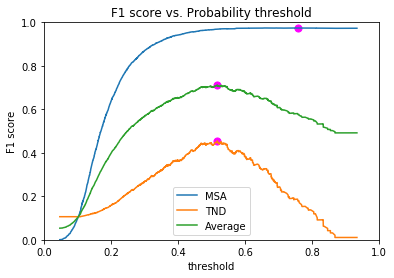

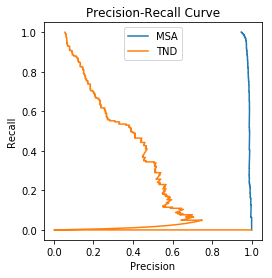

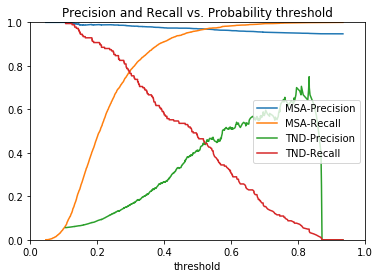

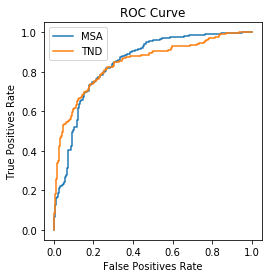

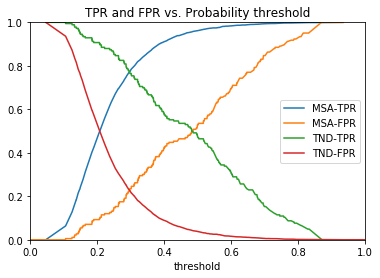

In [33]:
my_utils.my_performance_report(y_test,bbc_model_lr.predict(X_test),bbc_model_lr.predict_proba(X_test),bbc_model_lr.classes_)

#### BalancedBaggingClassifier with Decision Tree as base estimator

In [34]:
## Source: https://www.kdnuggets.com/2019/05/fix-unbalanced-dataset.html

#Create an instance of the classifier.

dt_base_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features=2, class_weight=None)

bbc_model = BalancedBaggingClassifier(base_estimator=dt_base_model, n_estimators=500,
                                      sampling_strategy=0.5,
                                      max_samples = 1.0,
                                      max_features = 1.0,
                                      oob_score = True,
                                      replacement=True, 
                                      random_state=20742)

#Train the classifier.
bbc_model.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=500, n_jobs=1, oob_score=True,
             random_state=20742, ratio=None, replacement=True,
             sampling_strategy=0.5, verbose=0, warm_start=False)

In [35]:
print(metrics.balanced_accuracy_score(y_train, bbc_model.predict(X_train)),
      metrics.balanced_accuracy_score(y_test, bbc_model.predict(X_test)))

0.9900178709328095 0.7144580294972313


------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.97      0.97      0.97      3289
         TND       0.46      0.46      0.46       183

   micro avg       0.94      0.94      0.94      3472
   macro avg       0.71      0.71      0.71      3472
weighted avg       0.94      0.94      0.94      3472

Average F1 score: 0.7144580294972313

Confusion matrix:
col_0   MSA  TND
row_0           
MSA    3190   99
TND      99   84


------------------------------------
Area Under the Curve:
------------------------------------
0.8570271496144626


------------------------------------
Maximum F1 Scores:
------------------------------------
                MSA       TND   Average
threshold  0.666000  0.504000  0.504000
max(F1)    0.975967  0.461538  0.715806

------------------------------------



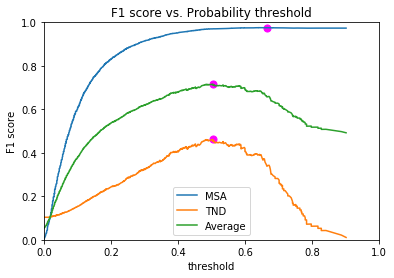

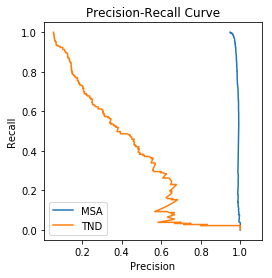

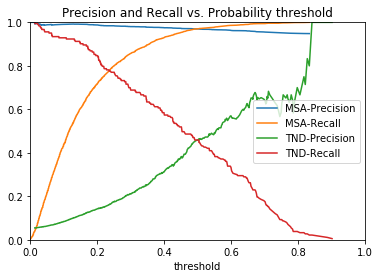

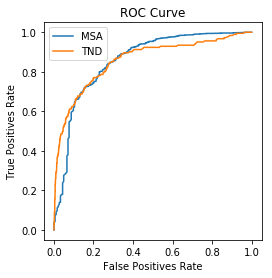

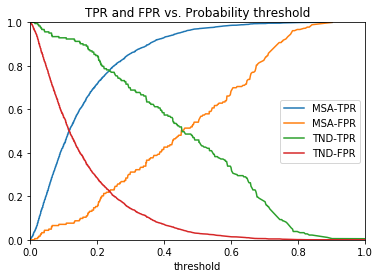

In [36]:
my_utils.my_performance_report(y_test,bbc_model.predict(X_test),bbc_model.predict_proba(X_test),bbc_model.classes_)

***

#### Forest of randomized trees

*"An ensemble method in which each tree of the forest will be provided a balanced bootstrap sample. This class provides all functionality of the `sklearn.ensemble.RandomForestClassifier` and notably the feature\_importances\_ attributes."*

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [38]:
# ?BalancedRandomForestClassifier

In [39]:
brf_model = BalancedRandomForestClassifier(n_estimators=500, 
                                           criterion='gini', 
                                           max_depth=None,
                                           max_features=5,
                                           oob_score=False, 
                                           sampling_strategy=0.5,
                                           replacement=True, 
                                           class_weight=None,
                                           verbose=0,
                                           random_state=0)
brf_model.fit(X_train, y_train) 

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features=5,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
                oob_score=False, random_state=0, replacement=True,
                sampling_strategy=0.5, verbose=0, warm_start=False)

In [40]:
print(metrics.balanced_accuracy_score(y_train, brf_model.predict(X_train)),
      metrics.balanced_accuracy_score(y_test, brf_model.predict(X_test)))

0.7726134611913757 0.7153660072405618


------------------------------------
Classification report with default cutoff threshold=0.5
------------------------------------

              precision    recall  f1-score   support

         MSA       0.97      0.97      0.97      3289
         TND       0.43      0.46      0.45       183

   micro avg       0.94      0.94      0.94      3472
   macro avg       0.70      0.72      0.71      3472
weighted avg       0.94      0.94      0.94      3472

Average F1 score: 0.708356660711738

Confusion matrix:
col_0   MSA  TND
row_0           
MSA    3178  111
TND      98   85


------------------------------------
Area Under the Curve:
------------------------------------
0.838796152766217


------------------------------------
Maximum F1 Scores:
------------------------------------
                MSA       TND   Average
threshold  0.661708  0.511772  0.511772
max(F1)    0.974625  0.465374  0.717954

------------------------------------



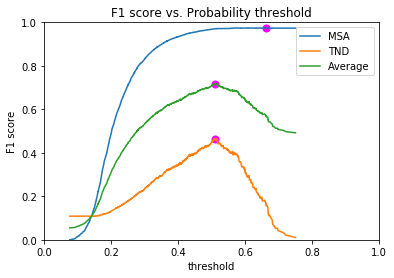

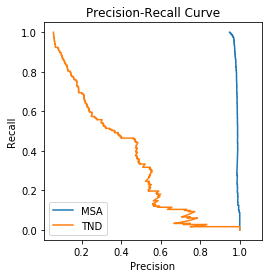

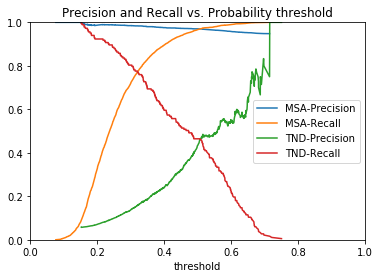

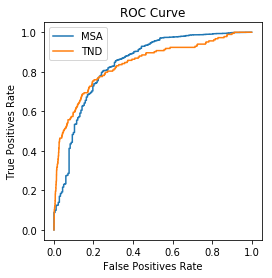

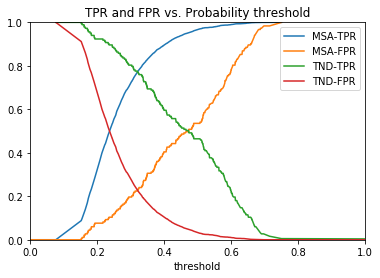

In [41]:
my_utils.my_performance_report(y_test,brf_model.predict(X_test),brf_model.predict_proba(X_test),brf_model.classes_)

Analysis of feature importance

In [42]:
feat_imp_RF = brf_model.feature_importances_  
type(feat_imp_RF),feat_imp_RF.shape

(numpy.ndarray, (500,))

Top 10 Features:
	 0.06355568603936482 "و "
	 0.032227933468370044 "و"
	 0.019618552481700607 "ش "
	 0.017964394982640325 " ا"
	 0.016800870316502344 "ي"
	 0.015571333263503302 "ا "
	 0.013720800663917607 "ه"
	 0.012801117869927084 "اي"
	 0.012620283380353614 " ي"
	 0.012496866669968033 "ش"

feature: "و "

Number of training words that contain this feature: 156

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
TND                    83    548    0.739765
MSA                    73   9868   15.145985

Example training words that contain this feature:
  MSA: ['خبو', 'فو', 'بورتوريكو', 'طهو', 'طوكيو', 'الكونغو', 'ماثيو', 'بيساو', 'تساو', 'جرو']
  TND: ['يعملو', 'بيدو', 'وجهو', 'شوفو', 'ممسطو', 'برفو', 'تعرفو', 'عندو', 'عملو', 'مرتو']

feature: "و"

Number of training words that contain this feature: 2132

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA       

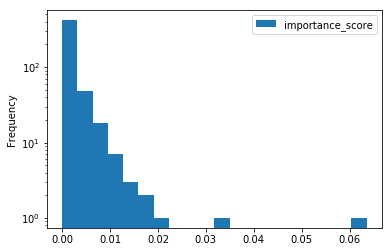

In [43]:
my_utils.analyze_feature_importance(feat_imp_RF,feature_names,words_train_df,X_train)